# Import Required Libraries
Import necessary libraries such as TensorFlow, Keras, NumPy, and Matplotlib.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
import os
from PIL import UnidentifiedImageError
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# Set Hyperparameters
Define hyperparameters including resolution of image, number of convolution layers, batch size, and epochs.

In [ ]:
# Define hyperparameters
image_resolution = (64, 64)  # Resolution of image
num_conv_layers = 3  # Number of convolution layers
batch_size = 32  # Batch size
epochs = 10  # Number of epochs


# Load and Preprocess Data
Load images from the local file path, split them into training and test sets, and preprocess them (resize, normalize).

In [ ]:
# Define file paths
train_data_dir = 'concrete_crack_images/training'
test_data_dir = 'concrete_crack_images/test'

# Define categories
categories = ['Negative', 'Positive']

# Function to load images and labels for training data
def load_data_with_error_handling(data_dir, categories, image_resolution):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        if not os.path.exists(category_path):
            print(f"Directory {category_path} does not exist.")
            continue
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                img = load_img(img_path, target_size=image_resolution)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(categories.index(category))
            except UnidentifiedImageError:
                print(f"Cannot identify image file {img_path}. Skipping.")
    return np.array(images), np.array(labels)

# Function to load images for test data
def load_test_data_with_error_handling(data_dir, image_resolution):
    images = []
    if not os.path.exists(data_dir):
        print(f"Directory {data_dir} does not exist.")
        return np.array(images)
    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_name)
        try:
            img = load_img(img_path, target_size=image_resolution)
            img_array = img_to_array(img)
            images.append(img_array)
        except UnidentifiedImageError:
            print(f"Cannot identify image file {img_path}. Skipping.")
    return np.array(images)


In [9]:
# Load training data
X_train, y_train = load_data_with_error_handling(train_data_dir, categories, image_resolution)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Load test data with labels
X_test = load_test_data_with_error_handling(test_data_dir, image_resolution)

# Print shapes of the datasets
print("")
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")

Cannot identify image file concrete_crack_images/training/Negative/.DS_Store. Skipping.
Cannot identify image file concrete_crack_images/training/Positive/.DS_Store. Skipping.
Cannot identify image file concrete_crack_images/test/.DS_Store. Skipping.

Training data shape: (25685, 64, 64, 3)
Validation data shape: (6422, 64, 64, 3)
Test data shape: (7893, 64, 64, 3)
Training labels shape: (25685,)
Validation labels shape: (6422,)


In [ ]:
# Initialize the CNN model
model = Sequential()
initial_filters = 32  # Initial number of filters

# Add convolutional layers based on the specified number of convolution layers
for i in range(num_conv_layers):
    filters = initial_filters * (2 ** i)
    if i == 0:
        # First layer needs to specify input shape
        model.add(Conv2D(filters, (3, 3), activation='relu', padding="same", input_shape=(image_resolution[0], image_resolution[1], 3)))
    else:
        model.add(Conv2D(filters, (3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
    model.add(Dropout(0.5))  # Add dropout layer with rate 0.5 after each convolutional block

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout layer with rate 0.5 after the fully connected layer

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a specific learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
start_time = time.time()
history = model.fit(
    X_train, 
    y_train, 
    batch_size=batch_size, 
    validation_data=(X_val, y_val), 
    epochs=epochs, 
    verbose=1, 
    callbacks=[early_stopping]
)
end_time = time.time()


/Users/Thomas/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,081 (4.36 MB)

 Trainable params: 1,142,081 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - accuracy: 0.6370 - loss: 8.4444 - val_accuracy: 0.9830 - val_loss: 0.0768
Epoch 2/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.9784 - loss: 0.0783 - val_accuracy: 0.9732 - val_loss: 0.1339
Epoch 3/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.9819 - loss: 0.0618 - val_accuracy: 0.9841 - val_loss: 0.0842
Epoch 4/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.9806 - loss: 0.0624 - val_accuracy: 0.9815 - val_loss: 0.1064
Epoch 5/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.9817 - loss: 0.0639 - val_accuracy: 0.9752 - val_loss: 0.1048
Epoch 6/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.9818 - loss: 0.0577 - val_accuracy: 0.9857 - val_loss: 0.0578
Epoch 7/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.9817 - loss: 0.0609 - val_accuracy: 0.9746 - val_loss: 0.0840
Epoch 8/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.9796 - loss: 0.0628 - 

In [12]:
# Print the computational time
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Print hyperparameters information
print(f"Hyperparameters:")
print(f"Image Resolution: {image_resolution}")
print(f"Number of Convolution Layers: {num_conv_layers}")
print(f"Batch Size: {batch_size}")
print(f"Epochs: {epochs}")
print("=====================================")

# Print the last epoch's accuracy and loss
print(f"Last Epoch Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Last Epoch Training Loss: {history.history['loss'][-1]:.4f}")
if 'val_accuracy' in history.history and 'val_loss' in history.history:
    print(f"Last Epoch Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Last Epoch Validation Loss: {history.history['val_loss'][-1]:.4f}")
else:
    print("Validation accuracy and loss are not available.")

Training Time: 399.59 seconds
Hyperparameters:
Image Resolution: (64, 64)
Number of Convolution Layers: 3
Batch Size: 32
Epochs: 10
Last Epoch Training Accuracy: 0.9829
Last Epoch Training Loss: 0.0545
Last Epoch Validation Accuracy: 0.9824
Last Epoch Validation Loss: 0.1167


Cannot identify image file concrete_crack_images/test/.DS_Store. Skipping.
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Predictions saved to predictions.csv
Number of 0 predictions: 6452
Number of 1 predictions: 1441


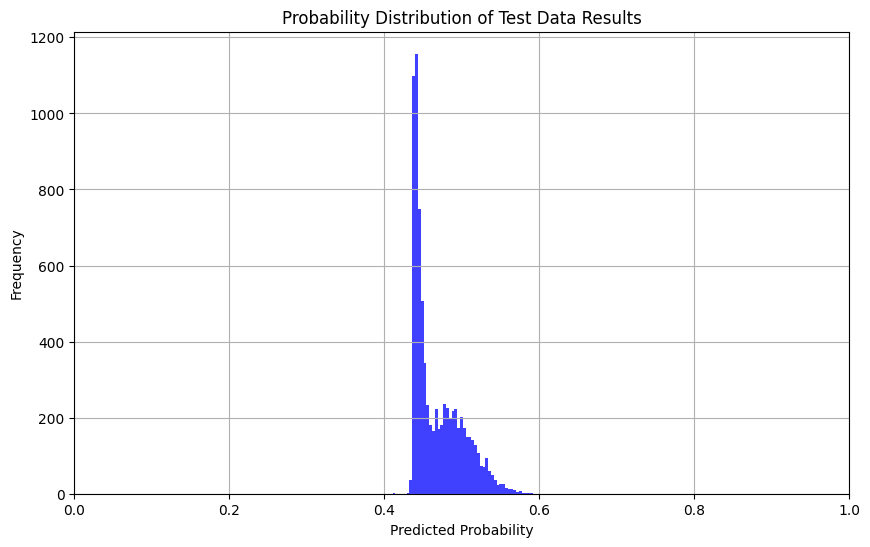

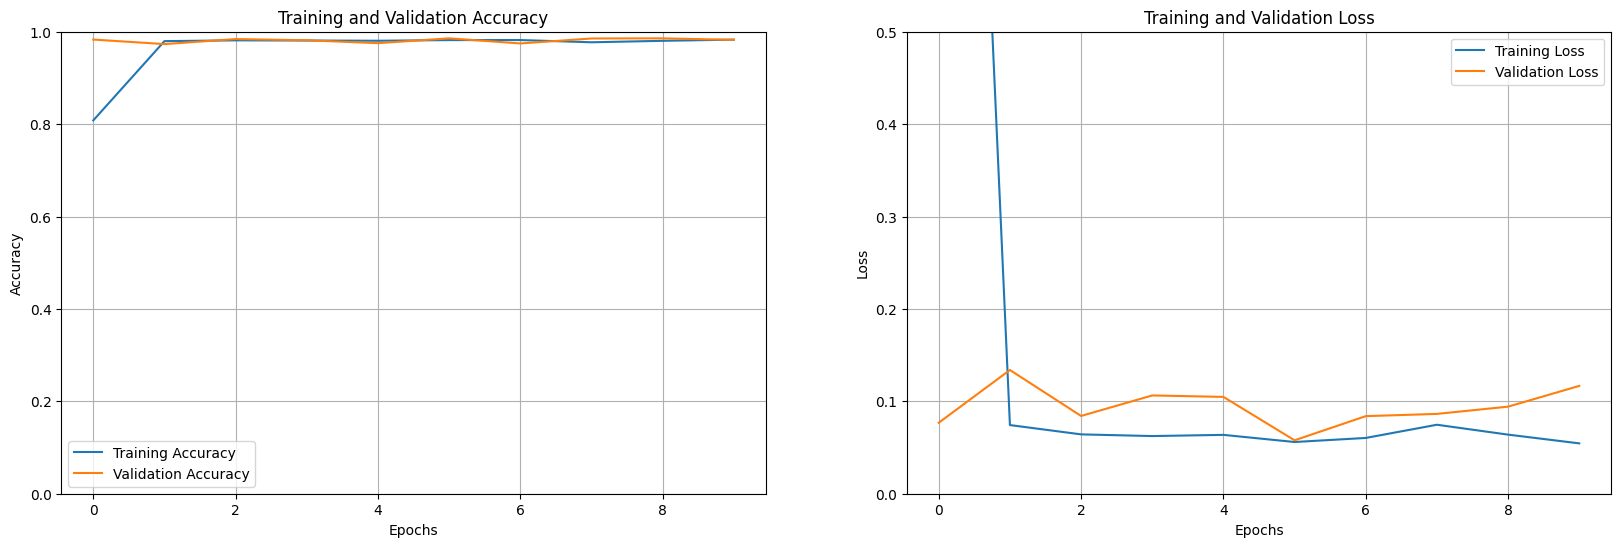

In [11]:
# Function to predict cracks in test images and save results to CSV
def predict_and_save_to_csv(model, test_data_dir, image_resolution, output_csv='predictions.csv'):
    # Load test data
    test_images = []
    image_ids = []
    for img_name in os.listdir(test_data_dir):
        img_path = os.path.join(test_data_dir, img_name)
        try:
            img = load_img(img_path, target_size=image_resolution)
            img_array = img_to_array(img)
            test_images.append(img_array)
            image_ids.append(img_name)
        except UnidentifiedImageError:
            print(f"Cannot identify image file {img_path}. Skipping.")
    
    # Convert to numpy array
    X_test = np.array(test_images)
    
    # Normalize the test images
    X_test = X_test / 255.0
    
    # Predict the classes
    predictions = model.predict(X_test)
    predicted_classes = [1 if pred > 0.5 else 0 for pred in predictions]
    
    # Create a DataFrame with image_id and predicted_class
    results_df = pd.DataFrame({
        'image_id': image_ids,
        'predicted_class': predicted_classes
    })
    
    # Save the DataFrame to a CSV file
    results_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")
    
    # Count the number of 0 and 1 predictions
    count_0 = predicted_classes.count(0)
    count_1 = predicted_classes.count(1)
    
    # Print the counts
    print(f"Number of 0 predictions: {count_0}")
    print(f"Number of 1 predictions: {count_1}")

    return predictions

# Call the function to predict and save results to CSV
predictions = predict_and_save_to_csv(model, test_data_dir, image_resolution)

# Function to plot the probability distribution of test data results
def plot_probability_distribution(predictions):
    plt.figure(figsize=(10, 6))
    plt.hist(predictions, bins=50, alpha=0.75, color='blue')
    plt.title('Probability Distribution of Test Data Results')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.xlim(0, 1)
    plt.show()

# Call the function to plot the probability distribution
plot_probability_distribution(predictions)

# Function to plot training and validation accuracy and loss side by side
def plot_accuracy_and_loss(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylim(0, 1)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylim(0, 0.5)

    plt.show()

# Call the function to plot accuracy and loss
plot_accuracy_and_loss(history)